In [1]:
from collections import defaultdict
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from data.synthetic_data import SyntheticDataset
from model import MLP, SharedBottom, OMOE, MMOE, CGC
from utils import losses

In [2]:
num_data = 10000
input_dim = 100
task_corr_list = [0.25, 0.5, 0.75, 1]

test_ratio  = 0.1
test_size  = int(num_data * test_ratio)
train_size = num_data - test_size

n_tasks = 2
n_experts = 8
n_shared_experts = 2
n_task_experts = [3,3]
expert_size = 16
tower_size = 8
total_param_size = (input_dim * expert_size * n_experts) + (expert_size * tower_size * n_tasks)
shared_size = round(total_param_size / (input_dim + tower_size * n_tasks))

learning_rate = 0.001
n_epochs = 10
mb_size = 10
num_mb  = num_data // mb_size

In [3]:
stl_name_list = ['single_task1', 'single_task2']
mtl_name_list = ['shared_bottom', 'omoe', 'mmoe', 'cgc']
model_name_list = stl_name_list + mtl_name_list

def init_model(model_type):
    if 'single' in model_type:
        model = MLP(
            input_size=input_dim,
            hidden_size=round(total_param_size/input_dim)
        )
    elif model_type == 'shared_bottom':
        model = SharedBottom(
            input_size=input_dim,
            shared_size=shared_size,
            tower_size=tower_size,
            num_tasks=n_tasks
        )
    elif model_type == 'omoe':
        model = OMOE(
            input_size=input_dim,
            expert_size=expert_size,
            tower_size=tower_size,
            num_tasks=n_tasks,
            num_experts=n_experts
        )
    elif model_type == 'mmoe':
        model = MMOE(
            input_size=input_dim,
            expert_size=expert_size,
            tower_size=tower_size,
            num_tasks=n_tasks,
            num_experts=n_experts
        )
    elif model_type == 'cgc':
        model = CGC(
            input_size=input_dim, 
            expert_size=expert_size, 
            tower_size=tower_size, 
            num_tasks=n_tasks, 
            num_shared_experts=n_shared_experts, 
            num_task_experts=n_task_experts
        )
    
    optims = torch.optim.Adam(model.parameters(), lr=learning_rate)
    return model, optims


In [ ]:
mse_loss = nn.MSELoss()
mtl_loss = losses.MultiTaskLoss()

models_dict  = dict()
history_dict = dict()
for task_corr in task_corr_list:
    print(f'Create dataset with task correlation {task_corr}..')
    dataset = SyntheticDataset(num_data, input_dim, task_corr=task_corr)
    train, test = torch.utils.data.random_split(
        dataset, [train_size, test_size]
    )
    dataloader = DataLoader(train.dataset, batch_size=mb_size, shuffle=True)

    models  = dict()
    history = defaultdict(list)
    for model_type in model_name_list:
        model, optims = init_model(model_type)

        print(f'Start training for model {model_type}..')
        for it in range(n_epochs):
            cost = 0
            for data in dataloader:
                X, y = data[0], data[1]
                y_st1, y_st2 = y[0], y[1]

                yhat = model(X)
                if model_type in mtl_name_list:
                    loss = mtl_loss(yhat, y)
                elif model_type == 'single_task1':
                    loss = mse_loss(yhat, y_st1.view(-1,1))
                elif model_type == 'single_task2':
                    loss = mse_loss(yhat, y_st2.view(-1,1))
                optims.zero_grad()
                loss.backward()
                optims.step()
                cost += (loss / num_mb)
            history[model_type].append(cost.item())
        models[model_type] = model
        
    print(f'Finish training for task correlation {task_corr}..')
    models_dict[task_corr]  = models
    history_dict[task_corr] = history

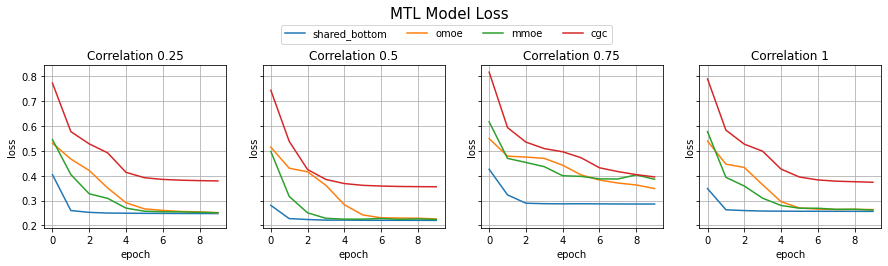

In [5]:
fig, axs = plt.subplots(1, len(task_corr_list), sharey=True, figsize=(15, 3))
plt.suptitle('MTL Model Loss', fontsize=15, y=1.15)
for ax, task_corr in zip(axs, task_corr_list):
    history = history_dict[task_corr]
    for model_type in mtl_name_list:
        ax.plot(history[model_type], label=model_type)
    ax.set_title(f'Correlation {task_corr}')
    ax.set(xlabel='epoch', ylabel='loss')
    ax.grid(True)

plt.legend(loc=(-2.3, 1.13), ncol=len(mtl_name_list))
plt.show()

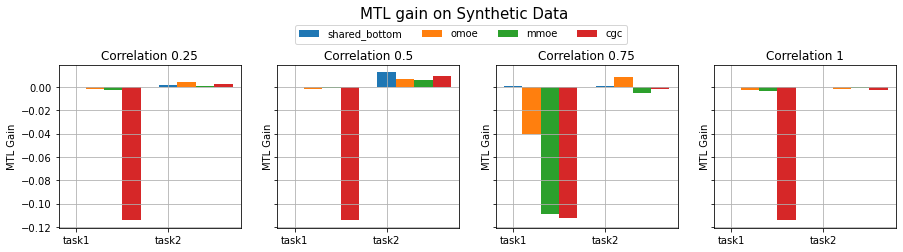

In [8]:
X_test = test.dataset.X
y1_test = test.dataset.y1.view(-1,1)
y2_test = test.dataset.y2.view(-1,1)

fig, axs = plt.subplots(1, len(task_corr_list), sharey=True, figsize=(15, 3))
plt.suptitle('MTL gain on Synthetic Data', fontsize=15, y=1.15)

labels = ['task1', 'task2']
width = 0.2
rects = np.arange(len(labels))

for ax, task_corr in zip(axs, task_corr_list):
    models = models_dict[task_corr]

    with torch.no_grad():
        yhat_st1 = models['single_task1'](X_test)
        yhat_st2 = models['single_task2'](X_test)
        loss_st1 = mse_loss(yhat_st1, y1_test)
        loss_st2 = mse_loss(yhat_st2, y2_test)

        for idx, model_type in enumerate(mtl_name_list):
            yhat1, yhat2 = models[model_type](X_test)
            loss1 = mse_loss(yhat1, y1_test)
            loss2 = mse_loss(yhat2, y2_test)
            mtl_gain1 = loss_st1 - loss1 
            mtl_gain2 = loss_st2 - loss2

            rect = [x + width*idx for x in rects]
            ax.bar(
                rect, [mtl_gain1, mtl_gain2],
                width=width, label=model_type
            )

    ax.set_title(f'Correlation {task_corr}')
    ax.set(ylabel='MTL Gain')
    ax.set_xticks(rects)
    ax.set_xticklabels(labels)
    ax.grid(True)

plt.legend(loc=(-2.3, 1.13), ncol=len(mtl_name_list))
plt.show()
